# Email Threat Detection System 🕵️‍♂️

It's not always easy to know whether a file you've downloaded and are preparing to execute is malicious.  How can we be better-prepared to tell the difference between benign and malicious executable files?

## The Goal:

Create a deep neural network, using tensorflow, with the intent on classifying image representations of portable executable files (PEs) so that, going forward, we can get a better understanding of the risk in opening files we get from unknown authors.

The 'benign' PEs were pulled from PC Magazine's [The Best Free Software of 2020](https://www.pcmag.com/news/best-free-software). The 'malicious' PEs were pulled from [the zoo](https://github.com/ytisf/theZoo).

Link to Kaggle dataset [here](https://www.kaggle.com/datasets/matthewfields/malware-as-images)

Images were generated using [Malook](https://github.com/raynt/mallook)

## Prepare our workspace

Let's import our dependancies, confirm working versions of those dependancies, set random seeds, and list any workspace variables that we will likely reuse throughput the notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import tensorflow_hub as hub
import os
import shutil
import cv2
import datetime
from matplotlib.pyplot import imread
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential

2023-11-23 12:33:17.842847: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print('TF Version: ', tf.__version__)
print('TF Hub Version: ', hub.__version__)
print('Pandas Version: ', pd.__version__)
print('Numpy Version: ', np.__version__)

TF Version:  2.14.0
TF Hub Version:  0.15.0
Pandas Version:  1.5.3
Numpy Version:  1.24.3


## Create common variables

In [3]:
MEASUREMENT = 'nearest'
DPI = "600"
IMAGE_SIZE = 224
WORKSPACE_BASE_URL = '../data/raw/'
PROCESSED_IMAGE_DIRECTORY = '../data/processed/processed_images'
RANDOM_STATE = 42

## Set random seeds for reproducability

In [4]:
tf.random.set_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

## Create dataframe containing filenames and label as malicious

In [5]:
# create helper function to generate dataframe containing filnames and labels
def create_df(measurement=MEASUREMENT, dpi=DPI):
    """
    collect names of files according to measurement and DPI
    create dataframe for filenames and labels
    """
    # collect pathnames
    benign_path = f'{WORKSPACE_BASE_URL}/portable_executables/benign/{measurement}_{dpi}'
    malicious_path = f'{WORKSPACE_BASE_URL}/portable_executables/malicious/{measurement}_{dpi}'
    # collect filenames
    benign_filenames = os.listdir(benign_path)
    malicious_filenames = os.listdir(malicious_path)
    # create dataframes
    df_benign = pd.DataFrame(benign_filenames, columns=['file_names'])
    df_malicious = pd.DataFrame(malicious_filenames, columns=['file_names'])
    # add labels
    df_benign['status'] = 'benign'
    df_malicious['status'] = 'malicious'
    # retrun concatonated dataframe
    return pd.concat([df_benign, df_malicious], ignore_index=True)

In [6]:
# create a dataframe
df = create_df()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file_names  136 non-null    object
 1   status      136 non-null    object
dtypes: object(2)
memory usage: 2.3+ KB


In [7]:
# confirm there are no duplicates
len(df[df.duplicated()]) == 0

True

## Visualizing the distribution of each status type

In [8]:
# Let's make a helper function to visualize this
def plot_status_distribution(dataframe):
    # Calculating the value counts and the percentage of each category
    value_counts = dataframe['status'].value_counts()
    percent = value_counts / value_counts.sum() * 100

    # Creating a bar plot
    plt.figure(figsize=(8, 6))
    bars = plt.bar(percent.index.map(str.upper), percent, color=['red' if x == 'malicious' else 'green' for x in percent.index])

    # Adding the distribution percentage on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom')  # Va='bottom' to place the text at the top of the bar

    # Setting labels and title
    plt.xlabel('Status')
    plt.ylabel('Percentage (%)')
    plt.title('Distribution of Status Categories')

    # Showing the plot
    plt.show()

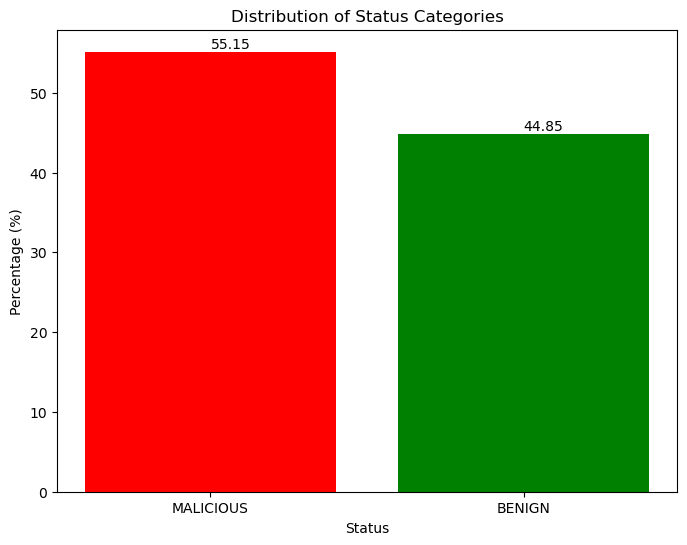

In [9]:
plot_status_distribution(df)

These label counts are slightly off balance, but not to the extent that this should pose a serious problem.

We may want to circle back in our `create_df` helper function to ensure these classes are properly balanced.

### Upsampling underrepresented classes
Since we do not have a lot of data, we should upsample the underrepresented classes (instead of downsampling the ocerrepresented classes) in order to achieve a balanced dataset

In [10]:
def upsample_minority_class(df):
    # Separate the DataFrame into two based on the status
    df_malicious = df[df['status'] == 'malicious']
    df_benign = df[df['status'] == 'benign']

    # Calculate the difference in number of entries
    sample_size = len(df_malicious) - len(df_benign)

    # Upsample the minority class (benign) to close the gap
    df_benign_upsampled = resample(
        df_benign, 
        replace=False,            # minimize duplicated rows
        n_samples=sample_size,    # to match the gap
        random_state=RANDOM_STATE # reproducible results
    )

    # Combine majority class with upsampled minority class
    return pd.concat([df_malicious, df_benign, df_benign_upsampled])

In [11]:
# update dataframe
df = upsample_minority_class(df)

In [12]:
# check number of duplicated rows
len(df[df.duplicated()])

14

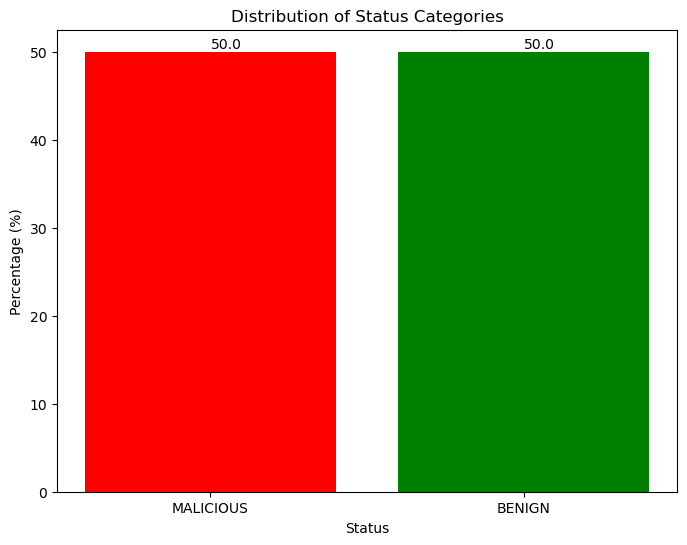

In [13]:
# check distribution is even
plot_status_distribution(df)

## Visualizing our images

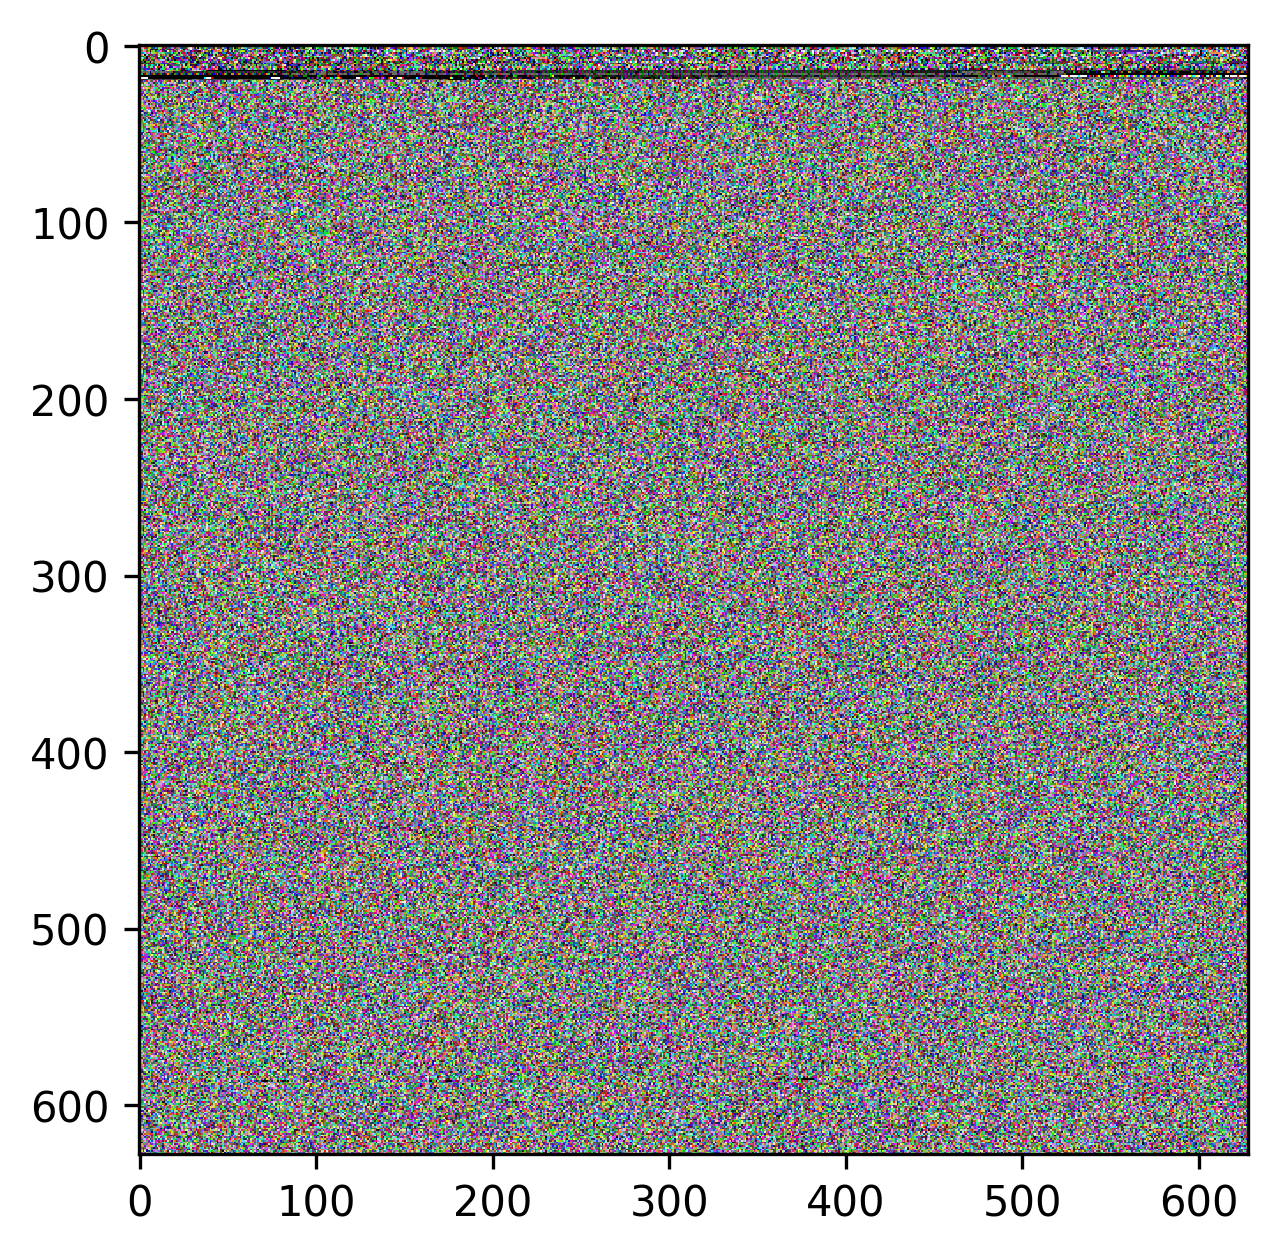

In [14]:
# Let's view an image within the notebook
from IPython.display import Image
Image(f"{WORKSPACE_BASE_URL}/portable_executables/benign/nearest_300/7z1900_nearest_300_.png")

This is a fairly large image.  We will likley have to downscale it and force dimension sizes on it.

Also, these images contain axis and margins that may confuse our model.  Perhaps we can strip these axis away?

In [15]:
source_dirs = [
  f'{WORKSPACE_BASE_URL}/portable_executables/benign/{MEASUREMENT}_{DPI}',
  f'{WORKSPACE_BASE_URL}/portable_executables/malicious/{MEASUREMENT}_{DPI}'
]
# create destination directory
destination_dir = PROCESSED_IMAGE_DIRECTORY

# let's create a helper function to preprocess these images and put them in a common directory
def process_images(
    measurement=MEASUREMENT,
    dpi=DPI,
    size=(IMAGE_SIZE, IMAGE_SIZE),
    trim_axis=True,
    destination_dir=destination_dir,
    source_dirs=source_dirs
):
  """
  gathers image files from both benign and malicious file directories,
  optionally remove axis imformation from the image
  resize the image to desired width & height
  distribute all files in processed images directory
  """
  # collect source directories
#   source_dirs = [
#       f'{WORKSPACE_BASE_URL}/portable_executables/benign/{measurement}_{dpi}',
#       f'{WORKSPACE_BASE_URL}/portable_executables/malicious/{measurement}_{dpi}'
#   ]
  # create destination directory
#   destination_dir = PROCESSED_IMAGE_DIRECTORY

  # Remove the directory if it exists
  if os.path.exists(destination_dir):
    shutil.rmtree(destination_dir)

  # Create the directory
  os.makedirs(destination_dir)

  # process each image
  for source_dir in source_dirs:
    for file_name in os.listdir(source_dir):
        file_path = os.path.join(source_dir, file_name)

        # Check if it's a file and not a directory
        if os.path.isfile(file_path):
            # Read the image
            image = cv2.imread(file_path)

            # optionally remove axis from image
            if trim_axis:
              # Convert to grayscale and threshold to isolate the spectrogram
              gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
              _, thresholded = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)

              # Find contours and get the largest one which should be the spectrogram
              contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
              largest_contour = max(contours, key=cv2.contourArea)

              # Get bounding box of the largest contour
              x, y, w, h = cv2.boundingRect(largest_contour)

              # Crop the image to the bounding box
              image = image[y:y+h, x:x+w]

            # Resize the cropped image
            resized_image = cv2.resize(image, size)

            # Save the processed image to the destination directory
            cv2.imwrite(os.path.join(destination_dir, file_name), resized_image)


In [16]:
process_images()

now that we have our images processed, let's update our dataframe to include the base path for that processed images directory

In [17]:
df['file_names'].iloc[0]

'Win32.Unclassified_nearest_600_.png'

In [18]:
df['file_names'] = f"{PROCESSED_IMAGE_DIRECTORY}/" + df['file_names']
df['file_names'].iloc[0]

'../data/processed/processed_images/Win32.Unclassified_nearest_600_.png'

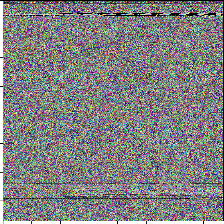

In [19]:
# let's view one of our processed images
impath = f'{PROCESSED_IMAGE_DIRECTORY}/Tojan.NSIS.Win32_{MEASUREMENT}_{DPI}_.png'
Image(impath)

Great!  We can confirm the axis have been cut off and the image has been trimmed in size.

## Exploratory Data Analysis

### Color Distribution Analysis

A good way to get a sense of how our `benign` samples differ from `malicious` ones is to plot the distribution of pixel intensities for each class

#### Pixel intensity for single image samples

In [20]:
# define a helper function to abstract this logic so it can be applied to both samples
def plot_color_histogram(image_path, title="Color Histogram"):
    # Read the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

    # Split into channels
    R, G, B = cv2.split(image)

    # Compute histograms for each channel
    histR = cv2.calcHist([R], [0], None, [256], [0, 256])
    histG = cv2.calcHist([G], [0], None, [256], [0, 256])
    histB = cv2.calcHist([B], [0], None, [256], [0, 256])

    # Plot the histograms
    plt.figure(figsize=(10, 4))
    plt.title(title)
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")

    plt.plot(histR, color='red')
    plt.plot(histG, color='green')
    plt.plot(histB, color='blue')

    plt.xlim([0, 256])
    plt.show()

##### For random 'benign' sample

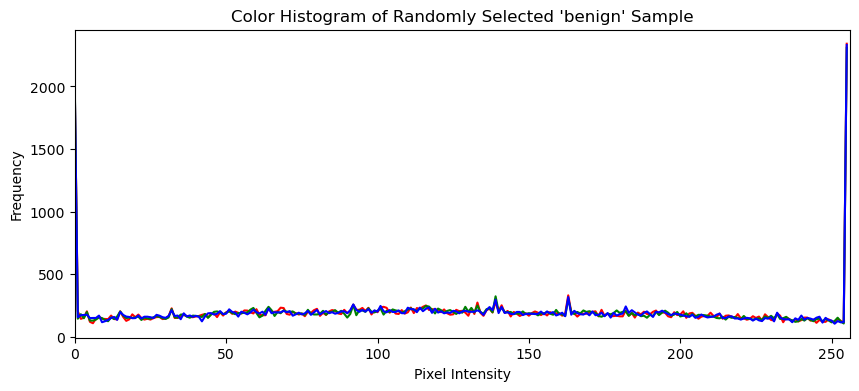

In [21]:
random_benign_entry = df[df['status'] == 'benign']['file_names'].sample(n=1).iloc[0]
plot_color_histogram(
    random_benign_entry,
    title="Color Histogram of Randomly Selected 'benign' Sample"
)

##### For random 'malicious' sample

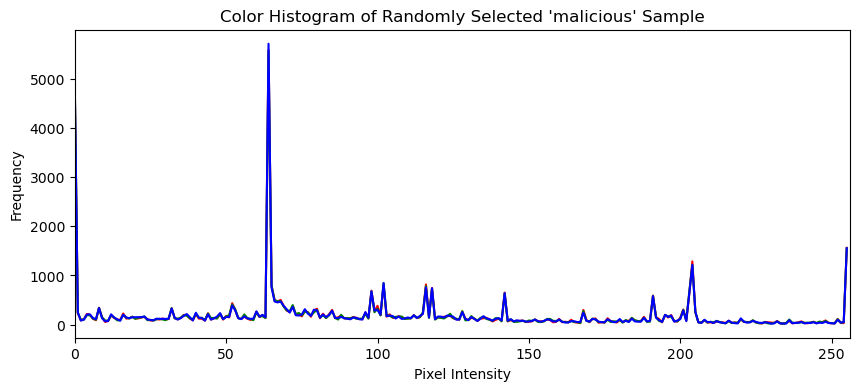

In [22]:
random_benign_entry = df[df['status'] == 'malicious']['file_names'].sample(n=1).iloc[0]
plot_color_histogram(
    random_benign_entry,
    title="Color Histogram of Randomly Selected 'malicious' Sample"
)

### Visualize color historgrams as an average per class

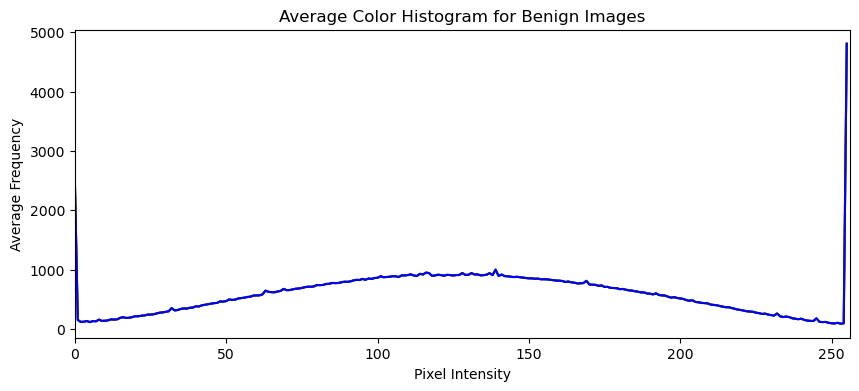

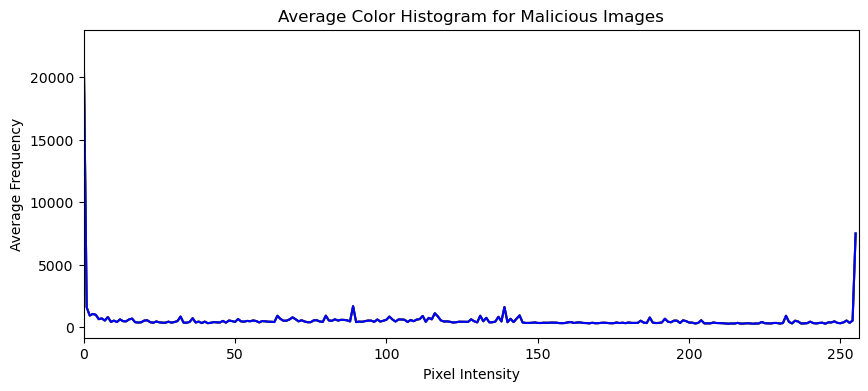

In [23]:
def compute_average_histogram(df, status):
    # Initialize sum of histograms
    sum_histR = sum_histG = sum_histB = np.zeros((256, 1), dtype='float32')

    # Filter dataframe for the given status
    df_status = df[df['status'] == status]

    for image_path in df_status['file_names']:
        # Read and process the image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Split into channels and compute histograms
        R, G, B = cv2.split(image)
        sum_histR += cv2.calcHist([R], [0], None, [256], [0, 256])
        sum_histG += cv2.calcHist([G], [0], None, [256], [0, 256])
        sum_histB += cv2.calcHist([B], [0], None, [256], [0, 256])

    # Compute average histograms
    avg_histR = sum_histR / len(df_status)
    avg_histG = sum_histG / len(df_status)
    avg_histB = sum_histB / len(df_status)

    return avg_histR, avg_histG, avg_histB

def plot_histograms(histR, histG, histB, title):
    plt.figure(figsize=(10, 4))
    plt.title(title)
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Average Frequency")
    plt.plot(histR, color='red')
    plt.plot(histG, color='green')
    plt.plot(histB, color='blue')
    plt.xlim([0, 256])
    plt.show()

# Compute and plot histograms for 'benign' class
avg_histR_benign, avg_histG_benign, avg_histB_benign = compute_average_histogram(df, 'benign')
plot_histograms(avg_histR_benign, avg_histG_benign, avg_histB_benign, "Average Color Histogram for Benign Images")

# Compute and plot histograms for 'malicious' class
avg_histR_malicious, avg_histG_malicious, avg_histB_malicious = compute_average_histogram(df, 'malicious')
plot_histograms(avg_histR_malicious, avg_histG_malicious, avg_histB_malicious, "Average Color Histogram for Malicious Images")

### Generating synthetic data
As we only have so many images available to us, it may pay off to generate flipped or rotated versions of these images to train on.

In [24]:
new_rows = []  # List to store new rows

for index, row in df.iterrows():
    # Read the image
    img = cv2.imread(row['file_names'])

    # Flip the image horizontally
    flipped_img = cv2.flip(img, 1)

    # Construct new file name
    file_path, file_ext = os.path.splitext(row['file_names'])
    new_file_name = f"{file_path}_horizontal-flip{file_ext}"

    # Save the flipped image
    cv2.imwrite(new_file_name, flipped_img)

    # Create a new row for the DataFrame
    new_row = {'file_names': new_file_name, 'status': row['status']}
    new_rows.append(new_row)

# Append new rows to the DataFrame
df_new = pd.DataFrame(new_rows)
df = pd.concat([df, df_new], ignore_index=True)

In [25]:
df.shape

(300, 2)

In [26]:
# Let's check if the number of entries we have in our dataframe
# match the number of images we just processed
filenames = os.listdir(PROCESSED_IMAGE_DIRECTORY)
if len(df) == len(filenames):
    print('it matches -- proceed!')
else:
  print('they do not match -- check for error!')
len(df), len(filenames)

they do not match -- check for error!


(300, 272)

In [27]:
df.head()

file_names     status
0  ../data/processed/processed_images/Win32.Uncla...  malicious
1  ../data/processed/processed_images/Kovter_near...  malicious
2  ../data/processed/processed_images/ZeroCleare....  malicious
3  ../data/processed/processed_images/Win32.Sofac...  malicious
4  ../data/processed/processed_images/Rustock_nea...  malicious

In [28]:
df = df.sample(frac=1).reset_index(drop=True)

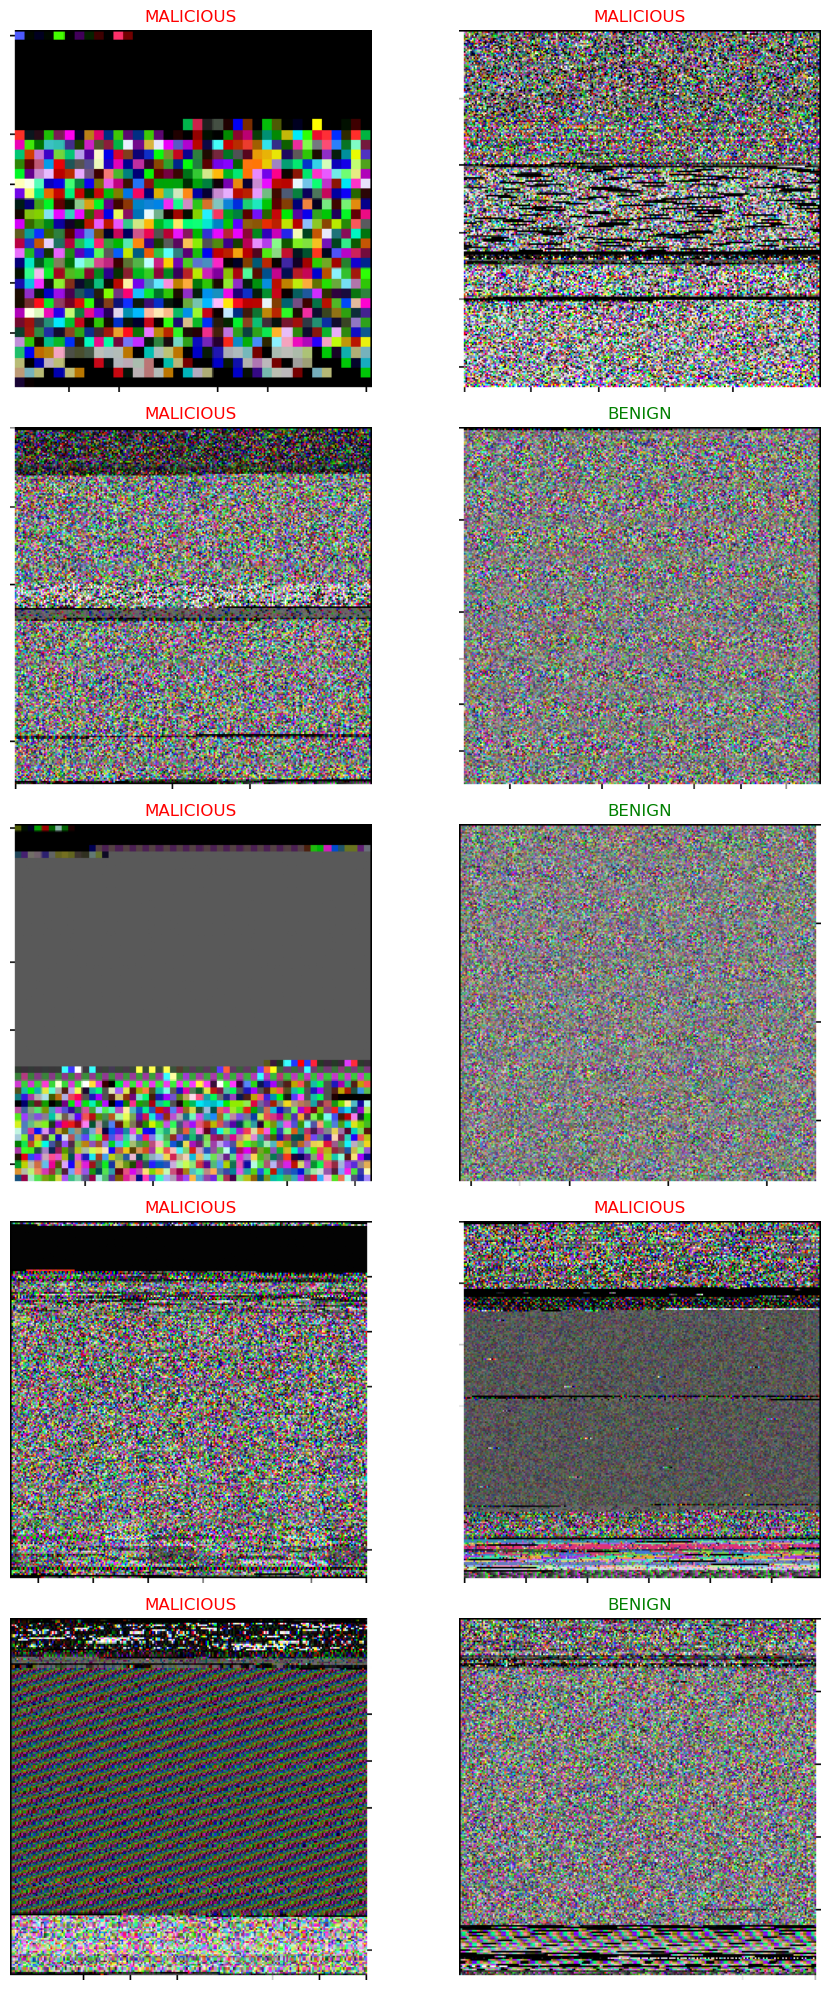

In [29]:
# Create a grid for plotting (5 rows, 2 columns)
fig, axs = plt.subplots(5, 2, figsize=(10, 20))

# Flatten the axes array for easy iteration
axs = axs.ravel()

# Loop over the first 10 rows of the DataFrame
for idx, row in enumerate(df.head(10).itertuples()):
    file_name = getattr(row, 'file_names')
    is_malicious = getattr(row, 'status') == 'malicious'

    # Load and display the image
    img = mpimg.imread(file_name)
    axs[idx].imshow(img)
    axs[idx].axis('off')  # Turn off axis

    # Display label
    label = "MALICIOUS" if is_malicious == True else "BENIGN"
    color = 'red' if is_malicious == True else 'green'
    axs[idx].set_title(f"{label}", color=color)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Create our own train, valid and test sets

now that we know the image paths we have in our dataframe can be accessed, we now need to create train and test sets

In [30]:
labels = df['status'].to_numpy()
filenames = df['file_names'].tolist()

In [31]:
# check if number of lables matches lenth of filenames
if len(labels) == len(filenames):
    print('it matches -- proceed!')
else:
  print('they do not match -- check for error!')

it matches -- proceed!


In [32]:
# get list of unique lables
unique_labels = np.unique(labels)
unique_labels

array(['benign', 'malicious'], dtype=object)

In [33]:
# the goal here is to have our 'y' be comprosed of an array of booleans 
# corresponding to each unique label
print(labels[0])
labels[0] == unique_labels

malicious


array([False,  True])

In [34]:
# Turn every label into a boolean array
boolean_labels = [label == unique_labels for label in labels]
boolean_labels[:2]

[array([False,  True]), array([False,  True])]

The goal here is to transofrm these boolean labels into a list of numbers that correspond to a 1 for true and a 0 for false

In [35]:
print(labels[0]) # origional label
print(filenames[0]) # corresponding filename
print(np.where(unique_labels == labels[0])) # index where label occours
print(boolean_labels[0].argmax()) # index where label occours in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occours

malicious
../data/processed/processed_images/Y-L3052_nearest_600_.png
(array([1]),)
1
[0 1]


In [36]:
filenames[:2]

['../data/processed/processed_images/Y-L3052_nearest_600_.png',
 '../data/processed/processed_images/CryptoLocker_20Nov2013_nearest_600_.png']

In [37]:
boolean_labels[:2]

[array([False,  True]), array([False,  True])]

this looks good -- I think we're ready to split our data into train and validation sets

In [38]:
X = filenames
y = boolean_labels
len(X), len(y)

(300, 300)

In [39]:
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE
)

len(X_train), len(y_train), len(X_val), len(y_val)

(240, 240, 60, 60)

In [40]:
# Let's have a look at the training data
X_train[:1], y_train[:1]

(['../data/processed/processed_images/ccsetup575_nearest_600_.png'],
 [array([ True, False])])

### Turning our images into tensors
*   Take an image file path as input
*   Use Tensorflow to read the file and save it to a variable
*   Turn our image into Tensors
*   Resize the image to be a shape of `IMAGE_SHAPE` variable
*   return the modified image

In [41]:
# check the shape of any given image
image = imread(X[42])
image.shape

(224, 224, 3)

In [42]:
# check min and max values
image.min(), image.max()

(0.0, 1.0)

In [43]:
# turn image into a tensor
tf.constant(image)

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [0.50980395, 0.5137255 , 0.33333334],
        [0.85490197, 0.44705883, 0.68235296],
        [0.        , 0.        , 0.        ]],

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [0.2509804 , 0.14117648, 0.38039216],
        [0.39607844, 0.7882353 , 0.59607846],
        [0.        , 0.        , 0.        ]],

       ...,

       [[1.        , 1.        , 1.        ],
        [1.  

In [44]:
# create a helper function for preproceesing the a single image
def process_image(image_path, img_size=IMAGE_SIZE):
  """
  Takes an image path and returns an image as a Tensor
  """
  # Take an image file path as input
  # Use Tensorflow to read the file and save it to a variable
  image = tf.io.read_file(image_path)
  # Turn our image into Tensors
  image = tf.image.decode_jpeg(image, channels=3)
  # convert the colour channel from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to be a shape of 224 X 224
  image = tf.image.resize(image, size=[img_size, img_size])
  # return the modified image
  return image

In [45]:
# create a helper function to create a tuple of tensors
def get_image_label(image_path, label):
  """
  Takes an image path name and associated label, and returns a tuple with image and associated label
  """
  image = process_image(image_path)
  return image, label

In [46]:
# demo of the above
(process_image(X[42]), y[42])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],
 
        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [0.50980395, 0.5137255 , 0.33333334],
         [0.854902  , 0.44705886, 0.68235296],
         [0.        , 0.        , 0.        ]],
 
        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [0.2509804 , 0.14117648, 0.3803922 ],
         [0.39607847, 0.78823537, 0.59607846],
         [0.        , 0.        , 0.        ]],
 
        ...,
 
        [[1.        , 1.        

### Create data batches

Now we've got a way to turn our data into tuples of tensors in the form of (image, label)

Let's make a function to turn all of our data into batches.

In [47]:
# define the batch size
BATCH_SIZE = 32

# create a funciton to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Create batches of data out of image X and label y pairs.
  It shuffles the data if it's training data, but does not shuffle if it's validation or test data.
  It also accepts test data with no labels
  """

  # If the data is a test dataset, we don't have lables
  if test_data:
    print('Creating test data batches...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths -- no labels
    data_batch = data.map(process_image).batch(batch_size)
    return data_batch

  # if it's a valid dataset, we do not need to shuffle it
  elif valid_data:
    print('Creating valid data batches...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y))) # including both file paths and labels
    data_batch = data.map(get_image_label).batch(batch_size)
    return data_batch

  else:
    print('Creating training data batches...')
    # Turn file paths and labels into tensors
    data = tf.data.Dataset.from_tensor_slices((
        tf.constant(X),
        tf.constant(y)
    )) # including both file paths and labels
    # shuffle path names and labels prior to mapping is faster than mapping unpacked image tensors
    data = data.shuffle(buffer_size=len(X))

    data = data.map(get_image_label)
    data_batch = data.batch(batch_size)
    return data_batch

In [48]:
# Create training, validation and test batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)
# test_data = create_data_batches(X_test, y_test, test_data=True)

Creating training data batches...
Creating valid data batches...


In [49]:
# Check out the data attricbutes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 2), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 2), dtype=tf.bool, name=None)))

In [50]:
# we can see that each batch has a length of 32, as we have defined in BATCH_SIZE
train_images, train_labels = next(train_data.as_numpy_iterator())
len(train_images), len(train_labels)

(32, 32)

### Visualizing data batches

In [51]:
def show_image_block(
    images,
    labels,
    num_images=15
):
  """
  Displays a block of images and their lables form a data batch
  """
  # set up the figure
  plt.figure(figsize=(10, 10))
  # Loop through num_images for diplaying the images
  for i in range(num_images):
    # Create subplots
    ax = plt.subplot(5, 5, i + 1)
    # Display an image
    plt.imshow(images[i])
    # Determine the label and convert to uppercase
    label = unique_labels[labels[i].argmax()].upper()
    # Set the title color based on the label value
    title_color = 'green' if label == 'BENIGN' else 'red'
    # Add the image label as the title
    plt.title(label, color=title_color)
    # Turn the grid lines off
    plt.axis('off')

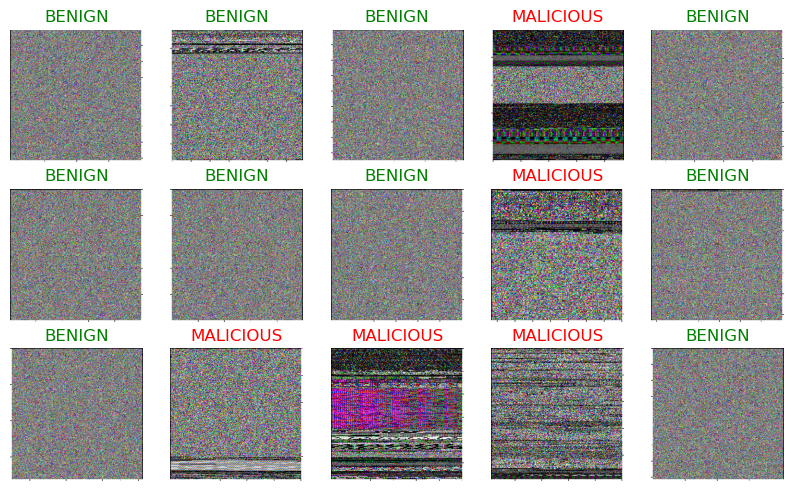

In [52]:
# let's visualize the data in a training batch
show_image_block(train_images, train_labels)

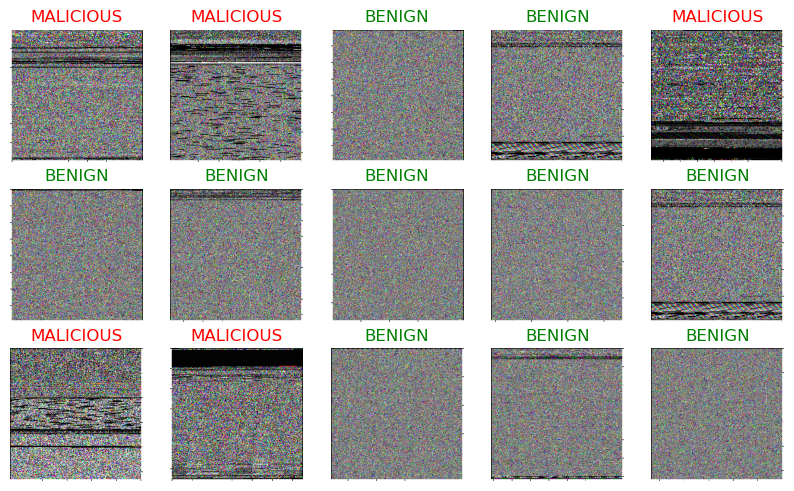

In [53]:
# and a validation batch
val_images, val_labels = next(val_data.as_numpy_iterator())
show_image_block(val_images, val_labels)

### Building a model

Before we build a model, there are a few things we need to define.

1.  the input shape -- our images shape in the form of tensors
2.  the ourput shape -- image labels in the form of tensors
3.  the URL fo the model we want to use from [Tensorflow Hub](https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5)

In [54]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMAGE_SIZE, IMAGE_SIZE, 3] # batch, height, width, colour channels

# set up the output shape
OUTPUT_SHAPE = len(unique_labels)

# set up URL from tensorflow hub
MODEL_URL = 'https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4' # Udemy vido has /4... consider changing this if issues occour RE: versions

In [55]:
# create a function which builds a keras model
def create_model(
    input_shape=INPUT_SHAPE,
    output_shape=OUTPUT_SHAPE,
    model_url=MODEL_URL
):
    print(f"Building a model with {model_url}")
    # set up the model layers
    model = tf.keras.Sequential([
      hub.KerasLayer(model_url), # layer one, the input layer
      tf.keras.layers.Dense(units=output_shape, activation="softmax") # Later two, the output layer
    ])
    # compile the model
    model.compile(
      optimizer=tf.keras.optimizers.Adam(),
      loss=tf.keras.losses.CategoricalCrossentropy(),
      metrics=['accuracy']
    )
    # build the model
    model.build(input_shape)
    return model

In [56]:
model = create_model()
model.summary()

Building a model with https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 2)                 2004      
                                                                 
Total params: 5434717 (20.73 MB)
Trainable params: 2004 (7.83 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________


### Create callbacks
We should create two basic callbacks for when we train our model
1.   tensorboard
2.   early-stopping

In [57]:
# load tensorboard notebook extension
%load_ext tensorboard

In [58]:
# create a function to build a tensorboard callback
def create_tensorboard_callback(dir=""):
    # create a log directory for storing tensorboard logs
    logdir = os.path.join(
        f"../reports/tensorboard_logs{dir}",
        # make it so the logs get tracked whenever we run an experiment
        datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    )
    return tf.keras.callbacks.TensorBoard(logdir)

In [59]:
# create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3
)

### Create a function that trains a model

1. create a model using create_model function
2. create a tensorboard callback using create_tensorboard_callback
3. call the .fit() method on the model using the training data, validation data, number of epochs to train for and the callbacks, which are the helper functions we would like to use.
4. return the model

In [60]:
NUM_EPOCHS = 100
# build a function to train, and return the trained model
def train_model():
    """
    trains a given model, and returns the trained version
    """
    # create a model
    model = create_model()

    # create a new tensorboard session every time we train a model
    tensorboard = create_tensorboard_callback()

    # fit the data to the model, passing it the callbacks we created
    model.fit(
      x=train_data,
      epochs=NUM_EPOCHS,
      validation_data=val_data,
      validation_freq=1,
      callbacks=[tensorboard, early_stopping]
    )

    return model

In [61]:
# fit our model to the data
mobile_net_model = train_model()

Building a model with https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
8/8 [==============================] - 11s 881ms/step - loss: 0.5725 - accuracy: 0.7750 - val_loss: 0.3194 - val_accuracy: 0.9000
Epoch 2/100
8/8 [==============================] - 6s 770ms/step - loss: 0.3149 - accuracy: 0.8792 - val_loss: 0.2256 - val_accuracy: 0.9000
Epoch 3/100
8/8 [==============================] - 6s 799ms/step - loss: 0.2782 - accuracy: 0.8875 - val_loss: 0.2052 - val_accuracy: 0.9167
Epoch 4/100
8/8 [==============================] - 8s 1s/step - loss: 0.2453 - accuracy: 0.9000 - val_loss: 0.1954 - val_accuracy: 0.9333
Epoch 5/100
8/8 [==============================] - 7s 899ms/step - loss: 0.2254 - accuracy: 0.9000 - val_loss: 0.1899 - val_accuracy: 0.9333
Epoch 6/100
8/8 [==============================] - 6s 826ms/step - loss: 0.2149 - accuracy: 0.9167 - val_loss: 0.1718 - val_accuracy: 0.9333
Epoch 7/100
8/8 [==============================] - 6s 805ms/st

### Checking the tensorboard logs

In [ ]:
%tensorboard --logdir ../reports/tensorboard_logs

Launching TensorBoard...

### Saving and loading a model

In [ ]:
# define helper function for saving a model
def save_model(model, suffix=None):
    """
    saves a given model in our models directry and appends a suffix string
    """
    # create a model directory with current time
    modeldir = os.path.join("../models", datetime.datetime.now().strftime('%Y%m%m%d-%H%M%s'))

    model_path = modeldir + '-' + suffix + '.h5' # save format for models
    print(f"saving model to {model_path}...")
    model.save(model_path)

    return model_path

In [ ]:
# and for loading a model into a notebook
def load_model(model_path):
    """
    loads a saved model from a specified path
    """
    print(f"loading saved model from {model_path}...")

    # load in our model!
    model = tf.keras.models.load_model(
      model_path,
      custom_objects={
          'KerasLayer': hub.KerasLayer # denote our layer imported from tensorhub
      }
    )

    return model

#### Save the model we just trained

In [ ]:
saved_model_url = save_model(mobile_net_model, suffix=f"{df.shape[0]}-images-mobilenetV2-Adam")

#### And load it back in

In [ ]:
mobile_net_model = load_model('../models/2023111121-17241700605473-300-images-mobilenetV2-Adam.h5')

### Making Predictions

In [ ]:
# make predictions on the validation data (NOT used to train on!!)
predictions = mobile_net_model.predict(
    val_data,
    verbose=1
)

In [ ]:
predictions.shape

In [ ]:
# look how the shape matches
len(y_val), len(unique_labels)

In [ ]:
# notice how the sum of all the prediction values adds to (or close to) 1
# This is what 'softmax' does for us
np.sum(predictions[0])

In [ ]:
# convert our prediction probabilities into the output format we expect: the label of a dog breed
index = 42
print(f"Max value (probablility of prediction): {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_labels[np.argmax(predictions[index])]}")

In [ ]:
# let's define a helper function to turn our prediction probabilities into labels that are clear to understand
def get_pred_label(prediction_probabilities):
  """
  turns an array of prediction probabilities into a label
  """
  return unique_labels[np.argmax(prediction_probabilities)]

# get a predictted label pased on an array pf prediction probabilities
pred_label = get_pred_label(predictions[index])
pred_label

Since our validation data is still in a abtch data set, we'll have to un-batchify it to make predictions on the validation images, and then compare those predictions to the validation labels.

In [ ]:
# create a function to un-batch a batched dataset
images_ = []
labels_ = []

# loop through un-batched data
for image, label in val_data.unbatch().as_numpy_iterator():
    images_.append(image)
    labels_.append(label)

images_[index], labels_[index]

In [ ]:
# let's see how well our predictions line up with the ground-truth labels
get_pred_label(labels_[0]), get_pred_label(predictions[0])

In [ ]:
# let's put this logic into a function
def unbatchify(data):
    """
    Takes in a batch of tensors, and return two lists -- images and labels
    """
    # define empty lists
    images = []
    labels = []

    # iterate over batch
    for image, label in data.unbatch().as_numpy_iterator():
        images.append(image)
        labels.append(unique_labels[np.argmax(label)])

    return images, labels

In [ ]:
# unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

In [ ]:
# let's see if our functionized version matches what we had out-putted above
get_pred_label(val_labels[0])

### Visualizing Predictions

Now we've got ways to get prediction labels, and validation labels, and validation images.  Let's make some functions to make these all a bit more visual.

We'll create a function which:

1. takes an array of prediction probabilities, an array of truth labels, and an array of images and integers.
2. convert the prediction probabilities to a predicted lable
3. plot the predicted label, it's predicted probability, the truth label, and the target image in a single plot.

In [ ]:
def plot_pred(prediction_probabilities, labels, images, n=1):
    """
    View the prediction, ground truth and image for sample n
    """
    pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

    # get the pred label
    pred_label = get_pred_label(pred_prob)

    # plot image and remove ticks
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

    # change the colour of hte title depending on if the prediction is right or wrong
    if (pred_label == true_label):
        color='green'
    else:
        color='red'

    # change plot title to be predicted, probability of prediction, and truth label
    plt.title("PRED: {} {:2.0f}% ACTUAL: {}".format(pred_label, np.max(pred_prob)*100, true_label), color=color)

In [ ]:
plot_pred(
    prediction_probabilities=predictions,
    labels=val_labels,
    images=val_images,
    n=42
)

Now we've got one function to visualize our model's predictions.  Let's make another to view our model's top 10 predictions.

The funciton will:
1.  take an input of prediction prob array, and a ground truth array, and an integer
2.  find the predicted label using get_pred_label
3.  find the top ten: prediction_probabilities indexes and values, and the prediction labels
4.  plot all of these vlaues and labels, colouring hte true label green

In [ ]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
    """
    plot the top ten highest confidences along with the truth label for sample 'n'
    """

    pred_prob, true_label = prediction_probabilities[n], labels[n]

    # get the pred label
    pred_label = get_pred_label(pred_prob)

    # find the top ten prediction confidence indexes
    top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]

    # find the top ten prediction confidence values
    top_10_pred_values = pred_prob[top_10_pred_indexes]

    # find the top ten prediction labels
    top_10_pred_labels = unique_labels[top_10_pred_indexes]

    # set up plot
    top_plot = plt.bar(
      np.arange(len(top_10_pred_labels)),
      top_10_pred_values,
      color="grey"
    )
    plt.xticks(
      np.arange(len(top_10_pred_labels)),
      labels=top_10_pred_labels,
      rotation='vertical'
    )

    # chaneg the colour of hte true label
    if np.isin(true_label, top_10_pred_labels):
        top_plot[np.argmax(top_10_pred_labels == true_label)].set_color('green')
    else:
        pass


In [ ]:
plot_pred_conf(
    prediction_probabilities=predictions,
    labels=val_labels,
    n=42
)

In [ ]:
# let's check out a few predictions and thier different values
i_multiplier = 20
num_rows = 4
num_cols = 2
num_images = num_rows * num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))

for i in range(num_images):
    # create a subplot
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    # plot predictions!
    plot_pred(
      prediction_probabilities=predictions,
      labels=val_labels,
      images=val_images,
      n=i+i_multiplier
    )
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_pred_conf(
      prediction_probabilities=predictions,
      labels=val_labels,
      n=i+i_multiplier
    )

plt.tight_layout(h_pad=1.0)
plt.show()

In [ ]:
model_accuracy = mobile_net_model.evaluate(val_data)[1]
print(f" The accuracy for this model is: {model_accuracy:.2f}")

In [ ]:
y_true = val_labels
y_pred = [get_pred_label(pred) for pred in predictions]
# confirm they are the same length
len(y_true) == len(y_pred)

### Create reusable function for scoring model performance

In [ ]:
def score_model(y_true, y_pred, cm_title):
    # gather metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label='malicious')
    recall = recall_score(y_true, y_pred, pos_label='malicious')
    f1 = f1_score(y_true, y_pred, pos_label='malicious')
    report = classification_report(y_true, y_pred)

    # print results
    print(f"Accuracy is {accuracy:.2f}")
    print(f"Precision for 'malicious' is {precision:.2f}")
    print(f"Recall for 'malicious' is {recall:.2f}")
    print(f"F1 Score for 'malicious' is {f1:.2f}")
    
    # Generating the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=['malicious', 'benign'])

    # Plotting the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['malicious', 'benign'], yticklabels=['malicious', 'benign'])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(cm_title)
    plt.show()

In [ ]:
score_model(y_true, y_pred, cm_title="Confusion Matrix for MobileNet V2 Model")

### Create Convolutional Neural Network

In [ ]:
cnn_model = Sequential([
    # Convolutional layer with 32 filters, kernel size of 3, and ReLU activation
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    # Second convolutional layer
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten the output to feed into the dense layers
    Flatten(),

    # Dense layer with 128 units and ReLU activation
    Dense(128, activation='relu'),

    # Dropout layer for regularization
    Dropout(0.5),

    # Output layer with 2 units (for binary classification) and softmax activation
    Dense(2, activation='softmax')
])

initial_learning_rate = 0.01

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Compile the model
cnn_model.compile(   
    optimizer=optimizer,
#     optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(), # try binary_crossentropy
    metrics=['accuracy']
)

# Display the model's architecture
cnn_model.summary()

In [ ]:
# create tensorboard callback
tensorboard = create_tensorboard_callback(dir='cnn')

# fit the model
# cnn_model.fit(
#     x=train_data,
#     epochs=NUM_EPOCHS,
#     validation_data=val_data,
#     validation_freq=1,
#     callbacks=[tensorboard, early_stopping]
# )

In [ ]:
# model_url = save_model(cnn_model, 'cnn-Adam')

In [ ]:
cnn_model = load_model('../models/2023111122-10421700667777-cnn-Adam.h5')

In [ ]:
model_accuracy = cnn_model.evaluate(val_data)[1]
print(f" The accuracy for the CNN model is: {model_accuracy:.2f}")

#### Create Confusion Matrix for CNN

In [ ]:
predictions = cnn_model.predict(val_data, verbose=0)
y_true = val_labels
y_pred = [get_pred_label(pred) for pred in predictions]
score_model(y_true, y_pred, cm_title="Confusion Matrix for Convolutional Neural Network")

### Evaluate Prediction performance

A key factor in determining how well this model will perform in the wild is the performance for generating predictions.  If this model is popular, it may have to generate hundreds of predictions per minute.

Optimizing the performance of such algorithms can additionally save money on extranous compute costs, which can add up over time.

In [ ]:
%%time
mobile_net_predictions = mobile_net_model.predict(
    val_data,
    verbose=0
)

In [ ]:
%%time
cnn_predictions = cnn_model.predict(
    val_data,
    verbose=0
)

This difference is not insignificant.  But, upon looking into a sependancy for this feature, Mallook, it appears that it may take quite a while to convert a portable executable to an image -- in exess of 30 seconds.  Given that, the ~1 second of performance difference is not significant enough for the CNN to be prioritized over the superier accuracy score of the MobileNet model.

For this reason, I beleive we should proceed with the MobileNet model.

### Train Final Model On All Data

In order to deliver the best possible model, we should retrain using all available data

In [ ]:
len(X), len(y)

In [ ]:
full_data = create_data_batches(X, y)

In [ ]:
full_model = create_model()

In [ ]:
# create full model callbacks
full_model_tensorboard = create_tensorboard_callback()

# there's no validation set when training on all the data, so we can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="accuracy",
    patience=3
)

In [ ]:
# full_model.fit(
#     x=full_data,
#     epochs=NUM_EPOCHS,
#     callbacks=[
#         full_model_tensorboard,
#         full_model_early_stopping
#     ]
# )

In [ ]:
# save_model(full_model, 'full-image-set-mobilenetv2-Adam')

In [ ]:
full_model = load_model('../models/2023111122-15431700685793-full-image-set-mobilenetv2-Adam.h5')

### Making Real-world Predictions
Now that we have a full model trainied, we should find some portable executable files of our own to start making predictions with

In [ ]:
# preprocess images before making predictions on them
process_images(
    source_dirs=['../data/external/test_image_files/'],
    destination_dir='../data/external/test_image_files/processed'
)

In [ ]:
# collect file names
test_path = '../data/external/test_image_files/processed/'
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames

In [ ]:
# create data batch
test_data = create_data_batches(test_filenames, test_data=True)

In [ ]:
test_predictions = full_model.predict(test_data, verbose=1)

In [ ]:
test_pred_labels = [get_pred_label(test_predictions[i]) for i in range(len(test_predictions))]

In [ ]:
# create function for bundling these results into a legible payload
def bundle_results(filenames, predictions):
    pred_labels = [get_pred_label(predictions[i]) for i in range(len(predictions))]
    result = []

    for file, prediction, label in zip(filenames, predictions, pred_labels):
        filename_without_path = os.path.basename(file)
        stripped_filename = filename_without_path.replace('_nearest_600_.png', '')
        result.append({
            "file_name": stripped_filename,
            "confidence": round(max(prediction), 2),
            "classification": label
        })

    return result

In [ ]:
results = bundle_results(test_filenames, test_predictions)

In [ ]:
df = pd.DataFrame(results)

# Sorting by confidence in descending order
df_sorted = df.sort_values(by='confidence', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x='confidence', y='file_name', data=df_sorted, hue='classification', dodge=False, palette={'benign': 'green', 'malicious': 'red'})
plt.title('File Classifications with Confidence Levels')
plt.xlabel('Confidence')
plt.ylabel('File Name')
plt.legend(title='Classification')

# Adding a dotted red line at confidence = 0.5
plt.axvline(0.5, color='red', linestyle='--')

# Adjusting the y-axis limits to ensure all bars are on the same side of the 0.5 marker
plt.xlim(0, 1.1)

plt.show()